# TODO
- ogarnac dbscan
- moze jeszcze cos z feature engineeringiem ale chyba nie trzeba


In [144]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import random

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN,MiniBatchKMeans
from sklearn import  mixture

from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler,RobustScaler

from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score

import re
# pip install nltk
import nltk
from collections import defaultdict

nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bartekb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bartekb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## data preparation

after tests we have decided to do some changes

we are going to apply pca with 5 components to reduce number of unnecessary variables

we also delete streams charts and plylists since these variables dont influence clustering in positive way

cyclical key encoding doesnt work

In [3]:
def split_artists(df, artist_col='artist(s)_name'):
    df_expanded = df.copy()
    df_expanded[artist_col] = df_expanded[artist_col].str.split(',')
    df_expanded = df_expanded.explode(artist_col)
    df_expanded[artist_col] = df_expanded[artist_col].str.lower().str.replace(' ', '')
    return df_expanded.reset_index(drop=True)
def calculate_mean_streams(df, artist_col='artist(s)_name', streams_col='streams'):
    mean_streams = df.groupby(artist_col)[streams_col].mean()
    return mean_streams.to_dict()
def process_artists(df, artist_avg_streams, artist_col='artist(s)_name', artist_count_col='artist_count'):
    def get_top_artist(artists, artist_avg_streams):
        artists = [artist.lower().replace(' ', '') for artist in artists]
        valid_artists = [artist for artist in artists if artist in artist_avg_streams]
        if valid_artists:
            top_artist = max(valid_artists, key=lambda artist: artist_avg_streams[artist])
        else:
            top_artist = random.choice(artists)
        return top_artist
    processed_df = df.copy()
    for i, row in processed_df.iterrows():
        artists = row[artist_col].split(',')
        top_artist = get_top_artist(artists, artist_avg_streams)
        processed_df.at[i, artist_col] = top_artist
            
    return processed_df
def assign_artist_popularity(df, artist_avg_streams, artist_col='artist(s)_name'):
    # Calculate the four quantiles for the dictionary values
    quantiles = pd.qcut(list(artist_avg_streams.values()), 4, labels=False, retbins=True)[1]
    
    # Function to assign popularity based on quantiles
    def get_popularity(artist, artist_avg_streams, quantiles):
        artist = artist.lower().replace(' ', '')
        avg_streams = artist_avg_streams.get(artist, None)
        if avg_streams is not None:
            if avg_streams <= quantiles[1]:
                return 1
            elif avg_streams <= quantiles[2]:
                return 2
            elif avg_streams <= quantiles[3]:
                return 3
            else:
                return 4
        else:
            return 1  # Assign 1 if artist is not in the dictionary
    
    # Create a new column 'artist_popularity' and assign values based on quantiles
    df['artist_popularity'] = df[artist_col].apply(lambda artist: get_popularity(artist, artist_avg_streams, quantiles))
    
    return df


In [344]:
# Changed function
def preprocess_data(df):
    
    # handle incorrect data ande missing values
    non_numeric_indexes = df[df['streams'].astype(str).str.contains('[a-zA-Z]')].index
    df.loc[non_numeric_indexes, 'streams'] = None
    df['streams'].fillna(524376116,inplace=True)
    df['streams'] = df['streams'].astype(float)
    df['in_deezer_playlists'] = df['in_deezer_playlists'].str.replace(',', '', regex=False)
    df['in_deezer_playlists'] = df['in_deezer_playlists'].astype(int)
    df['in_shazam_charts'] = df['in_shazam_charts'].str.replace(',', '', regex=False)
    df['in_shazam_charts'] = df['in_shazam_charts'].astype(float)
    df['key'].fillna('G',inplace=True)

    # encode categorical variables
    key_order = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', np.nan]
    ordinal_encoder = OrdinalEncoder(categories=[key_order], handle_unknown='use_encoded_value', unknown_value=-1)
    df['key'] = df['key'].astype(object)
    encoded_keys = ordinal_encoder.fit_transform(df[['key']])
    df['key'] = encoded_keys

    
    # cyclically encode key
    max_value = 11
    #df['key' + '_sin'] = np.sin(2 * np.pi * df['key'] / max_value)
    #df['key' + '_cos'] = np.cos(2 * np.pi * df['key'] / max_value)
   

    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.array(['Major', 'Minor'])
    df['mode'] = label_encoder.fit_transform(df['mode'])
    #df['month_sin'] = np.sin(2 * np.pi * df['released_month'] / 12)
    #df['day_sin'] = np.sin(2 * np.pi * df['released_day'] / 31)
    bins = [float('-inf'), 1989, 1999, 2010, 2015, 2019, 2020, 2021, 2022, 2023]
    labels = ['1930-1989', '1990-1999', '2000-2010', '2011-2015', '2016-2019', '2020', '2021', '2022', '2023']
    df['year_group'] = pd.cut(df['released_year'], bins=bins, labels=labels, right=True, include_lowest=True)
    ordinal_mapping = {label: idx for idx, label in enumerate(labels)}
    df['year_group_encoded'] = df['year_group'].map(ordinal_mapping)
    df['year_group_encoded'] = df['year_group_encoded'].astype(float)


    # as for now we will not use 'track name' column

    #assign artist popularity
    df2 = pd.read_csv('../Data/spotify_modelling.csv')
    non_numeric_indexes = df2[df2['streams'].astype(str).str.contains('[a-zA-Z]')].index
    df2.loc[non_numeric_indexes, 'streams'] = None
    df2['streams'].fillna(524376116,inplace=True)
    df2['streams'] = df2['streams'].astype(float)
    pop = calculate_mean_streams(split_artists(df2))
    df = process_artists(df,pop)
    df = assign_artist_popularity(df,pop)



    # Normalize numeric columns
    #cols_to_normalize =['streams','in_spotify_charts','in_spotify_playlists','bpm','danceability_%','valence_%','energy_%','acousticness_%','instrumentalness_%','liveness_%','speechiness_%', 'key', 'year_group_encoded', 'artist_popularity']
    cols_to_normalize =['streams','in_spotify_charts','in_spotify_playlists','bpm','danceability_%','valence_%','energy_%','acousticness_%','instrumentalness_%','liveness_%','speechiness_%', 'key', 'year_group_encoded', 'artist_popularity']
    # scaling mode to reduce its impact
    df['mode'] = df['mode']/3
    scaler = MinMaxScaler()
    df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])
  
    df['streams'] =np.log1p(df.streams)
    df['in_spotify_charts'] =np.log1p(df.in_spotify_charts)
    df['in_spotify_playlists'] =np.log1p(df.in_spotify_playlists)


    # multiply to increase imporance of some features ????? these features should matter the most so i think it is a good idea
    # można popróbować jeszcze z innymi kolumnami 
    
    columns_to_multiply = ['energy_%','acousticness_%','speechiness_%','danceability_%']
    df[columns_to_multiply] = df[columns_to_multiply] * 10


    # drop unnecessary columns
    df.drop(columns=['streams','in_spotify_charts','in_spotify_playlists','year_group','in_apple_charts' ,'in_shazam_charts', 'in_deezer_charts','in_apple_playlists','in_deezer_playlists','artist(s)_name','track_name','artist_count','released_year','released_month','released_day'],axis='columns',inplace=True)
    #df.drop(columns='key',axis='columns',inplace=True)

    
    #PCA Transformation with 5 components
    pca = PCA(n_components=5)  
    df = pd.DataFrame(pca.fit_transform(df))

    return df
    

In [268]:
#Function used in km2

def preprocess_data2(df):
    
    # handle incorrect data ande missing values
    non_numeric_indexes = df[df['streams'].astype(str).str.contains('[a-zA-Z]')].index
    df.loc[non_numeric_indexes, 'streams'] = None
    df['streams'].fillna(524376116,inplace=True)
    df['streams'] = df['streams'].astype(float)
    df['in_deezer_playlists'] = df['in_deezer_playlists'].str.replace(',', '', regex=False)
    df['in_deezer_playlists'] = df['in_deezer_playlists'].astype(int)
    df['in_shazam_charts'] = df['in_shazam_charts'].str.replace(',', '', regex=False)
    df['in_shazam_charts'] = df['in_shazam_charts'].astype(float)
    df['key'].fillna('G',inplace=True)

    # encode categorical variables
    key_order = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', np.nan]
    ordinal_encoder = OrdinalEncoder(categories=[key_order], handle_unknown='use_encoded_value', unknown_value=-1)
    df['key'] = df['key'].astype(object)
    encoded_keys = ordinal_encoder.fit_transform(df[['key']])
    df['key'] = encoded_keys
    # cyclically encode key
    max_value = 11
    #df['key' + '_sin'] = np.sin(2 * np.pi * df['key'] / max_value)
    #df['key' + '_cos'] = np.cos(2 * np.pi * df['key'] / max_value)
    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.array(['Major', 'Minor'])
    df['mode'] = label_encoder.fit_transform(df['mode'])
    #df['month_sin'] = np.sin(2 * np.pi * df['released_month'] / 12)
    #df['day_sin'] = np.sin(2 * np.pi * df['released_day'] / 31)
    bins = [float('-inf'), 1989, 1999, 2010, 2015, 2019, 2020, 2021, 2022, 2023]
    labels = ['1930-1989', '1990-1999', '2000-2010', '2011-2015', '2016-2019', '2020', '2021', '2022', '2023']
    df['year_group'] = pd.cut(df['released_year'], bins=bins, labels=labels, right=True, include_lowest=True)
    ordinal_mapping = {label: idx for idx, label in enumerate(labels)}
    df['year_group_encoded'] = df['year_group'].map(ordinal_mapping)
    df['year_group_encoded'] = df['year_group_encoded'].astype(float)
    # as for now we will not use 'track name' column

    #assign artist popularity
    df2 = pd.read_csv('../Data/spotify_modelling.csv')
    non_numeric_indexes = df2[df2['streams'].astype(str).str.contains('[a-zA-Z]')].index
    df2.loc[non_numeric_indexes, 'streams'] = None
    df2['streams'].fillna(524376116,inplace=True)
    df2['streams'] = df2['streams'].astype(float)
    pop = calculate_mean_streams(split_artists(df2))
    df = process_artists(df,pop)
    df = assign_artist_popularity(df,pop)

    # Normalize numeric columns
    #cols_to_normalize =['streams','in_spotify_charts','in_spotify_playlists','bpm','danceability_%','valence_%','energy_%','acousticness_%','instrumentalness_%','liveness_%','speechiness_%', 'key', 'year_group_encoded', 'artist_popularity']
    cols_to_normalize =['streams','in_spotify_charts','in_spotify_playlists','bpm','danceability_%','valence_%','energy_%','acousticness_%','instrumentalness_%','liveness_%','speechiness_%', 'key', 'year_group_encoded', 'artist_popularity']
    df['instrumentalness_%'] = np.log1p(df['instrumentalness_%'])
    df['mode'] = df['mode']/3
    scaler = MinMaxScaler()
    df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])
    df['streams'] =np.log1p(df.streams)
    df['in_spotify_charts'] =np.log1p(df.in_spotify_charts)
    df['in_spotify_playlists'] =np.log1p(df.in_spotify_playlists)


    # increase imporance of some features ?????
    columns_to_multiply = ['energy_%','acousticness_%','bpm']
    #df[columns_to_multiply] = df[columns_to_multiply] * 10


    # drop unnecessary columns
    df.drop(columns=['streams','in_spotify_charts','in_spotify_playlists','year_group','in_apple_charts' ,'in_shazam_charts',
     'in_deezer_charts','in_apple_playlists','in_deezer_playlists',
    'artist(s)_name','track_name','artist_count','released_year','released_month','released_day'],axis='columns',inplace=True)
    

    return df

    

In [269]:
df = pd.read_csv('../Data/spotify_modelling.csv')
df = preprocess_data(df)
df.head(10)

,0,1,2,3,4
0,-1.428762,-0.185455,-1.364131,-1.979258,-0.612692
1,-2.756073,-1.217543,-0.554549,-0.068574,0.434023
2,-0.060246,1.008801,0.061945,0.198574,-0.645861
3,-0.229138,-0.225308,-0.709078,-1.768250,-0.069244
4,5.859477,0.348743,-1.291530,0.653441,0.070684
5,8.042367,-1.858918,0.177751,1.279134,-0.511339
6,-3.134766,2.177157,-0.929638,1.865813,-0.066039
7,-2.165441,-0.962211,-0.215301,-0.249307,-0.729748
8,-3.262184,-0.992591,-0.493318,-0.633875,0.397506
9,1.676361,2.938207,2.895028,-1.229226,0.081569


plan :
- define functions to do pca and tsne visualizations
- pick metric to evaluate models with 
- test and pick best params for models:
**Kmeans, hierarchical clustering, dbscan, gmm**
- pick best one

## Visualization functions

In [270]:
def pca_visualization(df,clusters):
    pca = PCA(n_components=2)  
    X_pca = pca.fit_transform(df)
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],hue=clusters, palette='tab20', legend='full')
    plt.title('K-means Clustering (PCA Visualization)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

In [271]:
def pca_3d(df,clusters):
    pca = PCA(n_components=3)  

    X_pca = pca.fit_transform(df)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters, cmap='tab20')

    ax.set_title('K-means Clustering (3D PCA Visualization)')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    legend1 = ax.legend(*scatter.legend_elements(), title='Clusters')
    ax.add_artist(legend1)

    plt.show()

In [272]:
def tsne_visualization(dataframe, predicted_clusters):
    tsne = TSNE(n_components=2, random_state=69)
    tsne_results = tsne.fit_transform(dataframe)
    tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df['Cluster'] = predicted_clusters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x='TSNE1', y='TSNE2',
        hue='Cluster',
        palette=sns.color_palette('hsv', len(set(predicted_clusters))),
        data=tsne_df,
        legend='full',
        alpha=0.7
    )
    plt.title('t-SNE Visualization of Clusters')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Cluster')
    plt.show()

## Cluster interpretation

In [273]:
# Function which returns table of clusters and columns. value 1 in column indicates that in this cluster value of this column is the highest in comparison to other clusters
# on average etc
# this function helps to interprete characteristics of clusters

def interprete_clusters(df,clusters):
    df2 =  df.copy()
    df2['cluster'] = clusters 
    c =df2.groupby('cluster').agg('mean')
    c= c.rank(ascending=False, method='average')
    return c

## Metrics

During hyperparameter optimalization we will evaluate model by these metrics:
- Silhouette score
- Davies-Bouldin score
- Caliński-Harabasz score

we will also take in account our subjective opinion about how well songs are clustered

In [274]:
def metrics(df,model):
    clusters = model.fit_predict(df)
    if len(set(clusters)) < 2:
        return [float('-inf'),float('inf'),float('-inf')]
    silhouette = silhouette_score(df,clusters)
    bouldin = davies_bouldin_score(df,clusters) 
    harabasz = calinski_harabasz_score(df,clusters)
    return [silhouette, bouldin, harabasz]

# Hyperparameter tuning

## Kmeans

In kmeans there is one main hyperparameter 
- n_clusters


In [275]:
# best random seed for kmeans
maxi =0
maxsil =-10
for i in range(2,100):
    model = KMeans(n_clusters = 5,random_state=i)
    x = metrics(df,model)
    if x[0]>maxsil:
        maxsil=x[0]
        maxi=i
print(maxi)

14


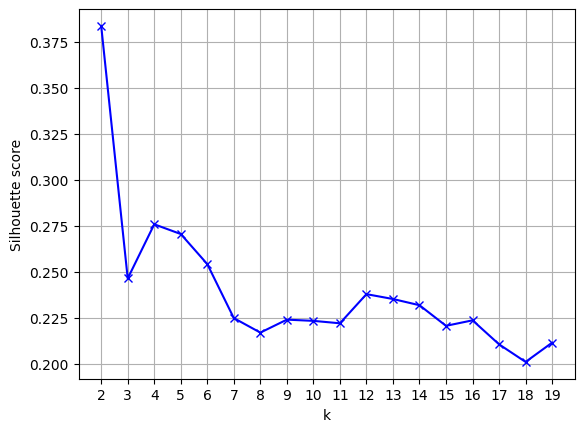

In [276]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k,random_state=42)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores
cluster_num_seq = range(2, 20)
silhouette_vec = count_clustering_scores(df, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.xticks(cluster_num_seq)
plt.grid(True)
plt.show()

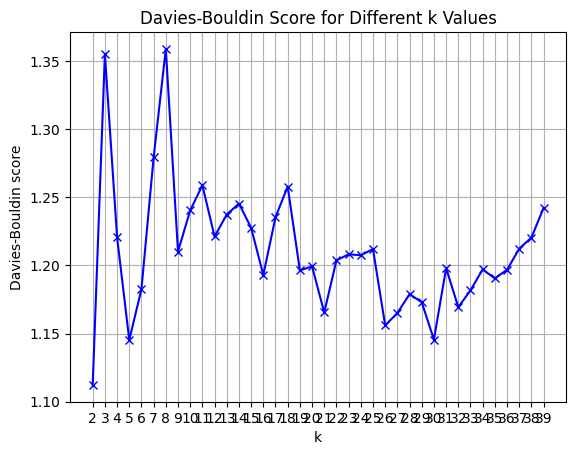

In [277]:
cluster_num_seq = range(2, 40)
#davies_bouldin_vec = count_clustering_scores(df, cluster_num_seq, KMeans, davies_bouldin_score)

davies_bouldin_vec = []
for k in cluster_num_seq:
    kmeans = KMeans(n_clusters=k,random_state=42)
    davies_bouldin_vec.append(davies_bouldin_score(df, kmeans.fit_predict(df)))


plt.plot(cluster_num_seq, davies_bouldin_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Davies-Bouldin score')
plt.title('Davies-Bouldin Score for Different k Values')
plt.xticks(cluster_num_seq)
plt.grid(True)
plt.show()


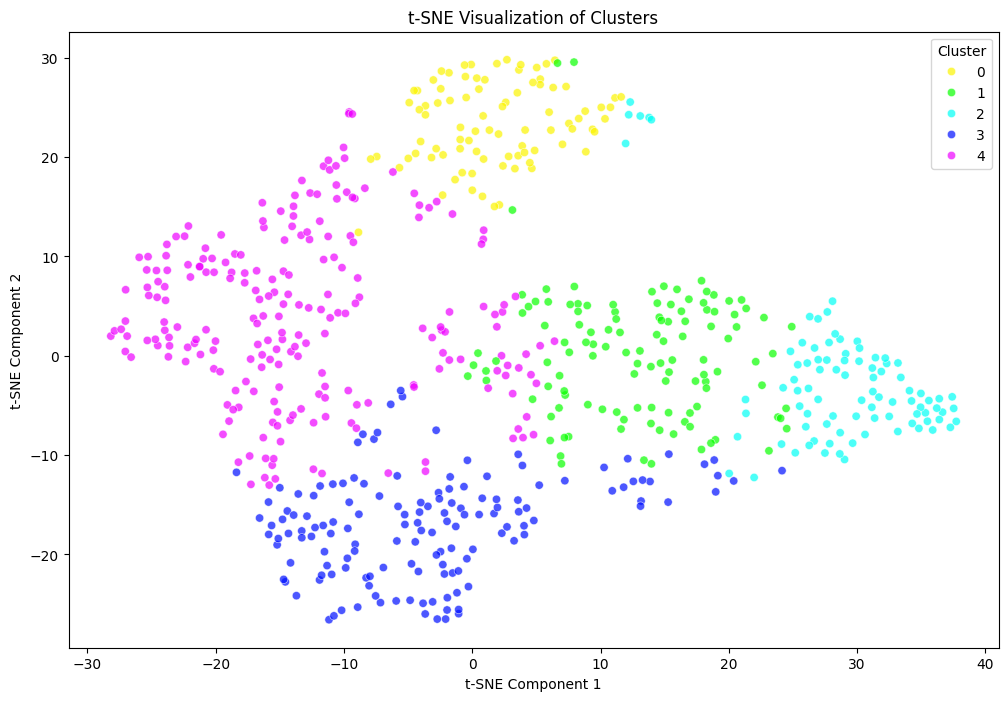

In [278]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=14)
clusters = kmeans.fit_predict(df)
tsne_visualization(df,clusters)

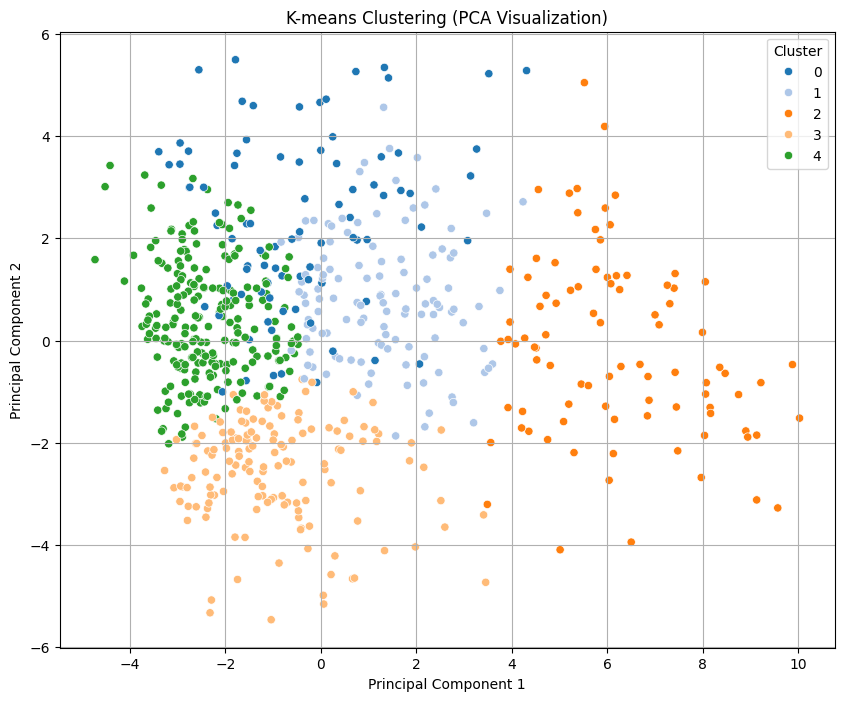

In [279]:
pca_visualization(df,clusters)

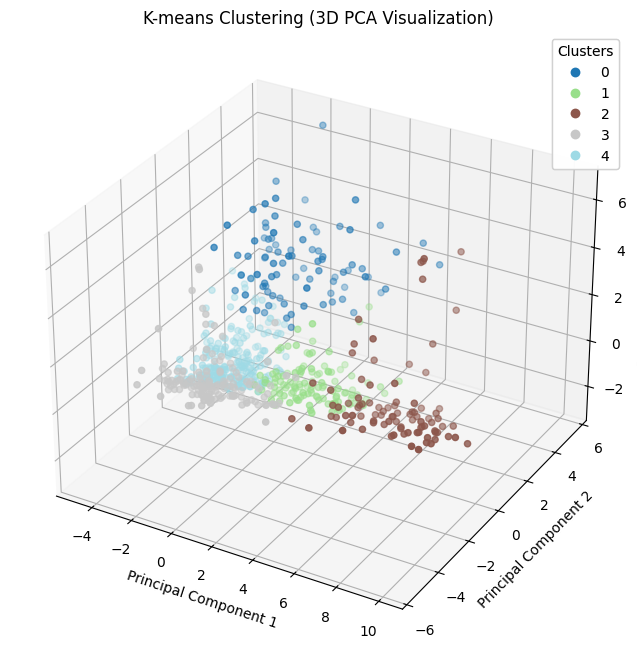

In [280]:
pca_3d(df,clusters)

In [281]:
metrics(df,kmeans)

[0.2721160758450148, 1.1369315266790376, 296.8450733663089]

## DBSCAN - DO POPRAWY

For this algorithm we will optimize two params:
- epsilon
- minPts

ps. dbscan probably will not be the best algorithm

psps it is very bad

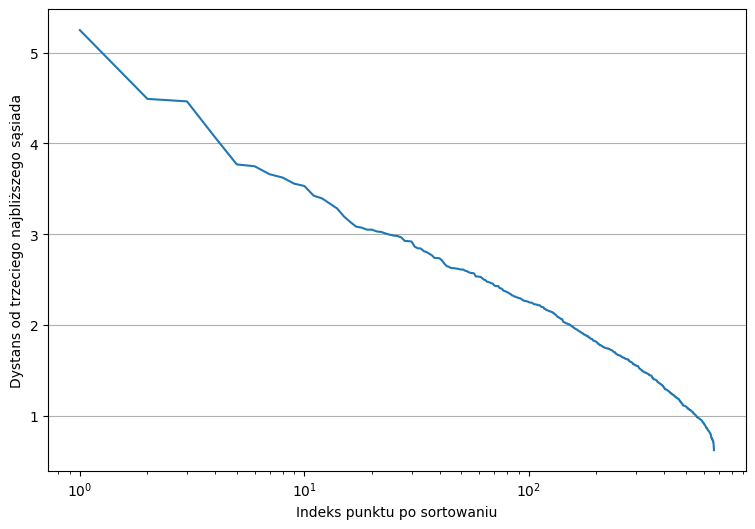

In [188]:
minPts = 10
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=minPts).fit(df)
distances, indices = nbrs.kneighbors(df)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od trzeciego najbliższego sąsiada')
ax1.plot(list(range(1,df.shape[0]+1)), distanceDec)

plt.xscale('log')
plt.grid(axis='y')

plt.show()

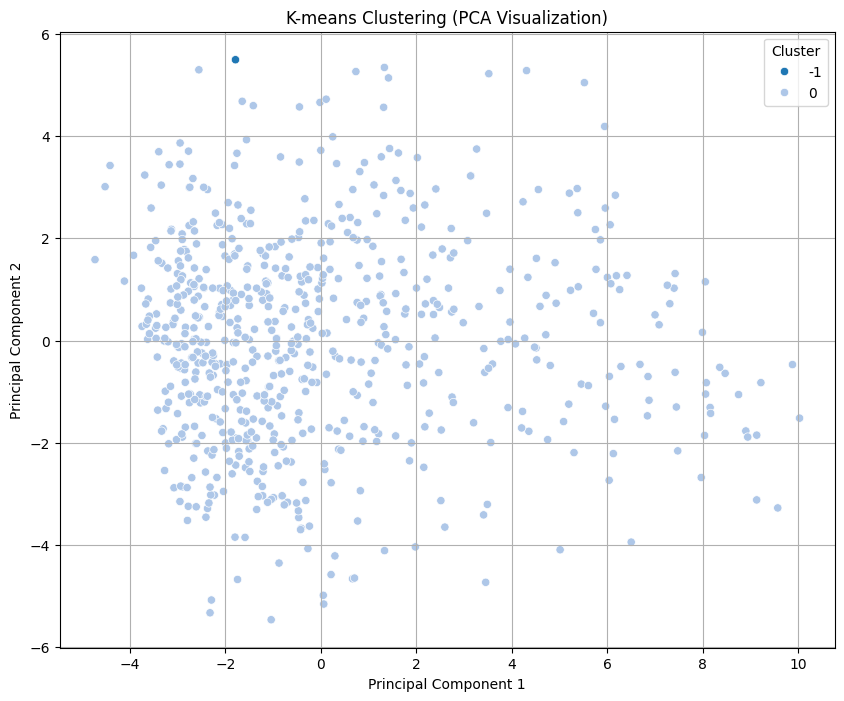

In [190]:
model = DBSCAN(eps = 3.5, min_samples = 10 )
pca_visualization(df,model.fit_predict(df))

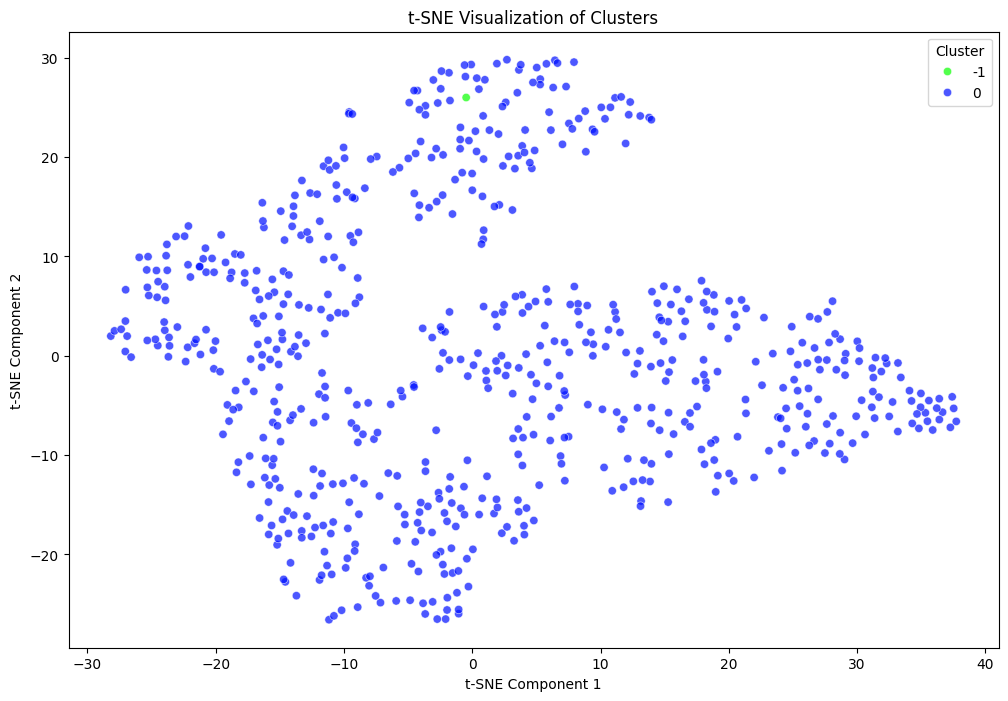

In [191]:
tsne_visualization(df,model.fit_predict(df))

In [194]:
metrics(df,model)

[0.46540226433747167, 0.3961152639029559, 5.379297119534006]

## GMM

In [284]:
from sklearn.model_selection import ParameterGrid
def find_best_gmm_params(data, param_grid):
    """
    Finds the best parameters for Gaussian Mixture Models based on silhouette score.

    Parameters:
    - data (pd.DataFrame or np.ndarray): The data to fit the GMM.
    - param_grid (dict): The parameter grid to search over. Keys are parameter names (as strings),
      and values are lists of parameter settings to try.

    Returns:
    - best_score (float): The highest silhouette score achieved.
    - best_params (dict): The parameters that correspond to the highest silhouette score.
    """
    
    best_score = -1
    best_params = None
    
    # Convert data to numpy array if it is a DataFrame
    if isinstance(data, pd.DataFrame):
        data = data.to_numpy()
    
    # Create a parameter grid
    grid = ParameterGrid(param_grid)
    
    for params in grid:
        # Fit GMM with current parameters
        gmm = mixture.GaussianMixture(**params,random_state=41)
        gmm.fit(data)
        labels = gmm.predict(data)
        
        # Calculate silhouette score
        score = silhouette_score(data, labels)
        
        # Update best score and parameters if current score is better
        if score > best_score:
            best_score = score
            best_params = params
            
    return best_score, best_params

In [285]:
param_grid = {
    'n_components': [4,5,6,7,8,9,10],
    'covariance_type': ['full', 'tied', 'diag', 'spherical']
}

best_score, best_params = find_best_gmm_params(df, param_grid)
print(f"Best Silhouette Score: {best_score}")
print(f"Best Parameters: {best_params}")

Best Silhouette Score: 0.25431172209627495
Best Parameters: {'covariance_type': 'spherical', 'n_components': 5}


In [286]:
gmm = mixture.GaussianMixture(n_components=5, covariance_type='spherical',random_state=13)
gmm_clusters = gmm.fit_predict(df)

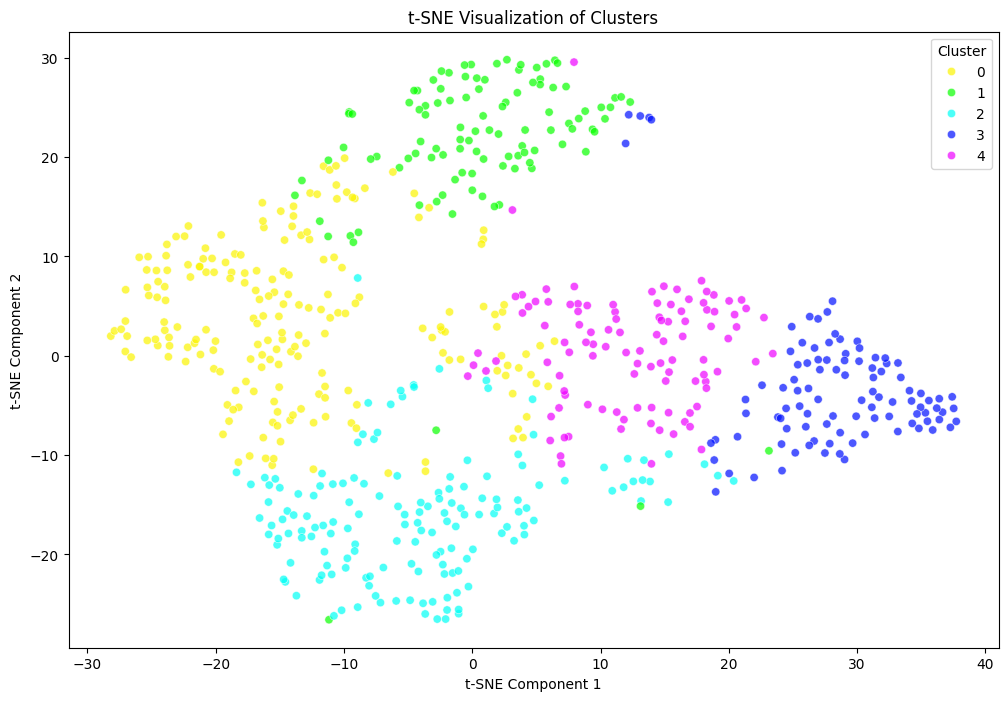

In [204]:
tsne_visualization(df,gmm_clusters)

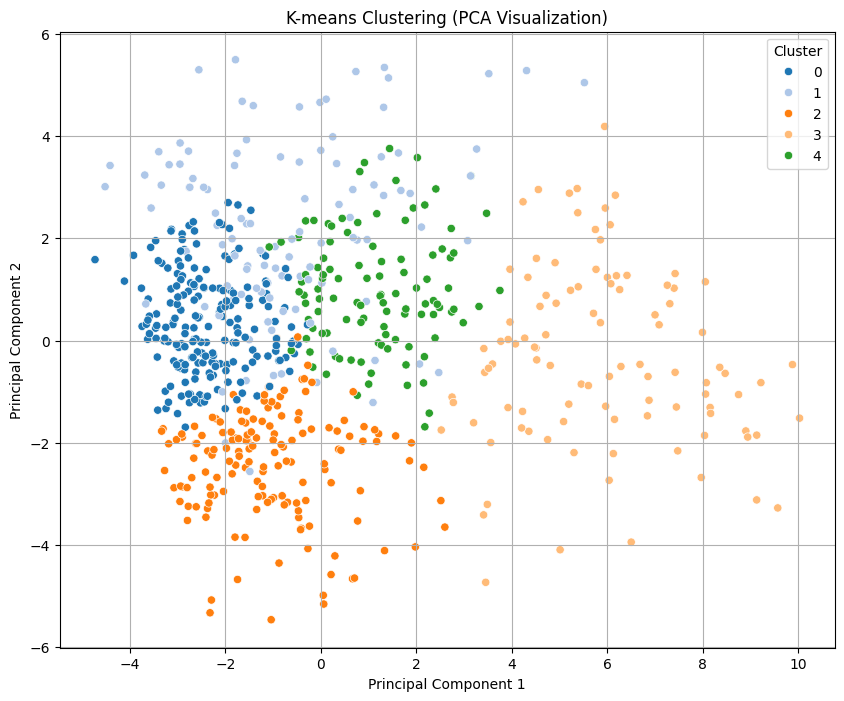

In [199]:
pca_visualization(df,bmm_clusters)

In [205]:
metrics(df,gmm)

[0.2534611921351647, 1.1784677151980822, 285.3662237289784]

## Hierarchical

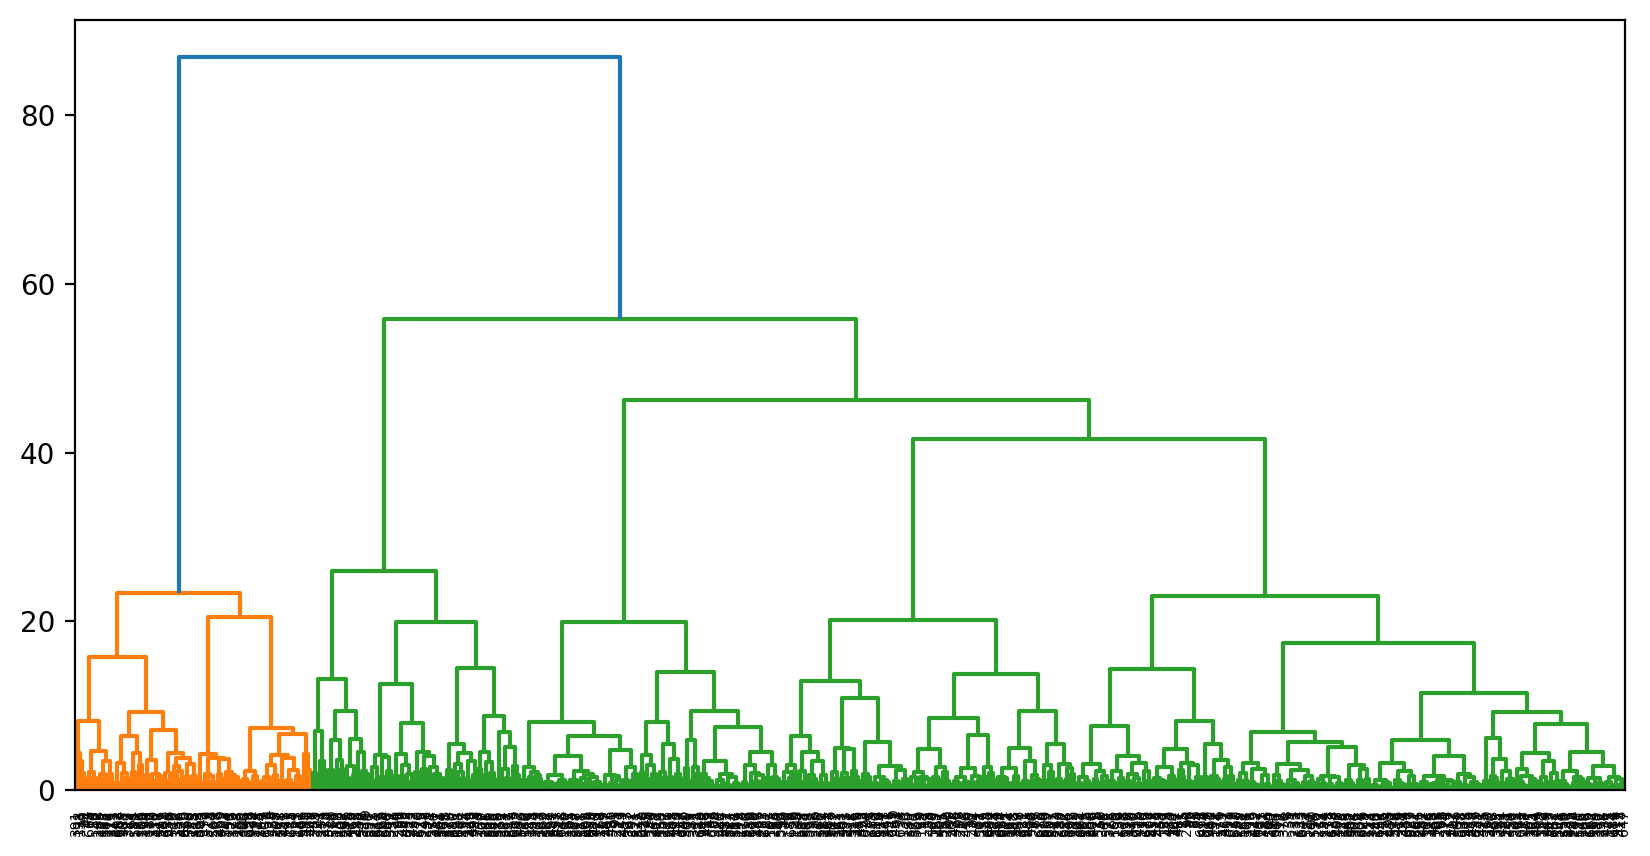

In [338]:
from scipy.cluster import hierarchy


Z = hierarchy.linkage(df, method='ward')
plt.figure(figsize=(10, 5), dpi= 200, facecolor='w', edgecolor='k')
hierarchy.dendrogram(Z)
plt.show()

fixed cluster number

silhouette optimalization

In [262]:
best_score = -1
best_params = None

for n_clusters in range(5, 10):
    for linkage_method in ['ward', 'complete', 'average', 'single']:
        clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method)
        labels = clustering.fit_predict(df)
        score = silhouette_score(df, labels)
        print(f'n_clusters: {n_clusters}, linkage: {linkage_method}, silhouette score: {score}')
        
        if score > best_score:
            best_score = score
            best_params = {'n_clusters': n_clusters, 'linkage': linkage_method}

print('Best parameters:', best_params)

n_clusters: 5, linkage: ward, silhouette score: 0.24107788316395126
n_clusters: 5, linkage: complete, silhouette score: 0.14562660280356132
n_clusters: 5, linkage: average, silhouette score: 0.3196653756126122
n_clusters: 5, linkage: single, silhouette score: 0.2188728402344135
n_clusters: 6, linkage: ward, silhouette score: 0.24729618326511008
n_clusters: 6, linkage: complete, silhouette score: 0.16517898122657962
n_clusters: 6, linkage: average, silhouette score: 0.2729684226823452
n_clusters: 6, linkage: single, silhouette score: 0.12747463237899256
n_clusters: 7, linkage: ward, silhouette score: 0.22773959501593682
n_clusters: 7, linkage: complete, silhouette score: 0.205657518465082
n_clusters: 7, linkage: average, silhouette score: 0.2176081576062868
n_clusters: 7, linkage: single, silhouette score: 0.13048459821140976
n_clusters: 8, linkage: ward, silhouette score: 0.19022013166120594
n_clusters: 8, linkage: complete, silhouette score: 0.20367888244373586
n_clusters: 8, linkage:

In [288]:
print(metrics(df,AgglomerativeClustering(n_clusters=5,linkage='average')))

[0.31966537561261205, 0.7953365344062566, 104.0063611508505]


harabasz optimalization

In [289]:
best_score = -1
best_params = None

for n_clusters in range(5, 10):
    for linkage_method in ['ward', 'complete', 'average', 'single']:
        clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method)
        labels = clustering.fit_predict(df)
        score = calinski_harabasz_score(df, labels)
        print(f'n_clusters: {n_clusters}, linkage: {linkage_method}, calinski harabasz: {score}')
        
        if score > best_score:
            best_score = score
            best_params = {'n_clusters': n_clusters, 'linkage': linkage_method}

print('Best parameters:', best_params)

n_clusters: 5, linkage: ward, calinski harabasz: 256.9153629759098
n_clusters: 5, linkage: complete, calinski harabasz: 171.80611843960872
n_clusters: 5, linkage: average, calinski harabasz: 104.0063611508505
n_clusters: 5, linkage: single, calinski harabasz: 6.270652540396258
n_clusters: 6, linkage: ward, calinski harabasz: 231.44732398323288
n_clusters: 6, linkage: complete, calinski harabasz: 168.7035484617445
n_clusters: 6, linkage: average, calinski harabasz: 123.10658882431375
n_clusters: 6, linkage: single, calinski harabasz: 5.5877688543210065
n_clusters: 7, linkage: ward, calinski harabasz: 212.91584778199052
n_clusters: 7, linkage: complete, calinski harabasz: 198.1620067888866
n_clusters: 7, linkage: average, calinski harabasz: 116.43939285830564
n_clusters: 7, linkage: single, calinski harabasz: 6.4319760309278795
n_clusters: 8, linkage: ward, calinski harabasz: 201.34286672004896
n_clusters: 8, linkage: complete, calinski harabasz: 183.4021019605583
n_clusters: 8, linkage:

In [290]:
print(metrics(df,AgglomerativeClustering(n_clusters=5,linkage='ward')))

[0.24107788316395112, 1.2356967866403967, 256.9153629759098]


bouldin optimalization

In [292]:
best_score = 1000000
best_params = None

for n_clusters in range(5, 10):
    for linkage_method in ['ward', 'complete', 'average', 'single']:
        clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method)
        labels = clustering.fit_predict(df)
        score = davies_bouldin_score(df, labels)
        print(f'n_clusters: {n_clusters}, linkage: {linkage_method}, davies-bouldin: {score}')
        
        if score < best_score:
            best_score = score
            best_params = {'n_clusters': n_clusters, 'linkage': linkage_method}

print('Best parameters:', best_params)

n_clusters: 5, linkage: ward, davies-bouldin: 1.2356967866403967
n_clusters: 5, linkage: complete, davies-bouldin: 1.7313291145697953
n_clusters: 5, linkage: average, davies-bouldin: 0.7953365344062566
n_clusters: 5, linkage: single, davies-bouldin: 0.5579458469199579
n_clusters: 6, linkage: ward, davies-bouldin: 1.2788148374554325
n_clusters: 6, linkage: complete, davies-bouldin: 1.6113575941185518
n_clusters: 6, linkage: average, davies-bouldin: 1.0530003256451832
n_clusters: 6, linkage: single, davies-bouldin: 0.5561793506402679
n_clusters: 7, linkage: ward, davies-bouldin: 1.3753447808405337
n_clusters: 7, linkage: complete, davies-bouldin: 1.4654470231509804
n_clusters: 7, linkage: average, davies-bouldin: 1.024663237634474
n_clusters: 7, linkage: single, davies-bouldin: 0.5656983286609452
n_clusters: 8, linkage: ward, davies-bouldin: 1.40583496018091
n_clusters: 8, linkage: complete, davies-bouldin: 1.3665536953794715
n_clusters: 8, linkage: average, davies-bouldin: 1.02304213016

In [293]:
print(metrics(df,AgglomerativeClustering(n_clusters=6,linkage='single')))

[0.12747463237899279, 0.5561793506402679, 5.5877688543210065]


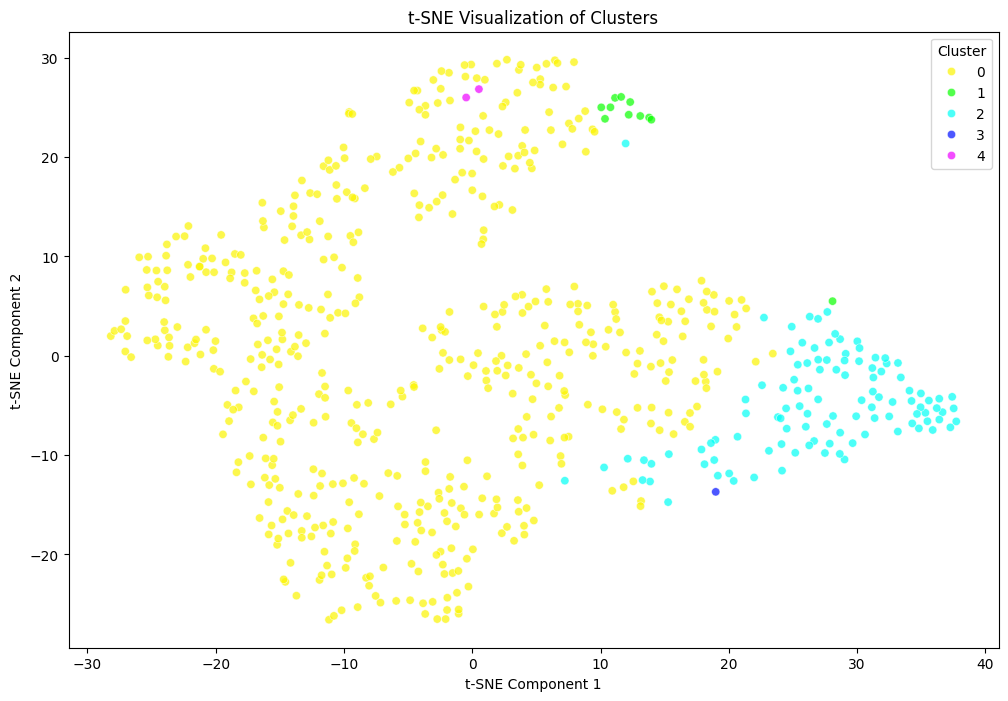

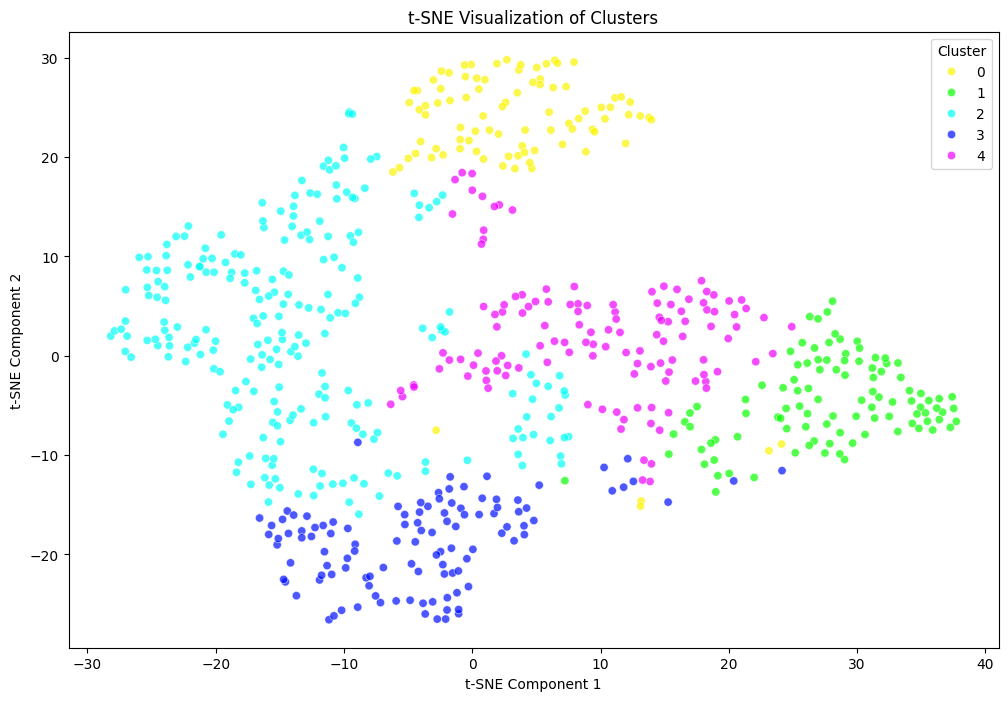

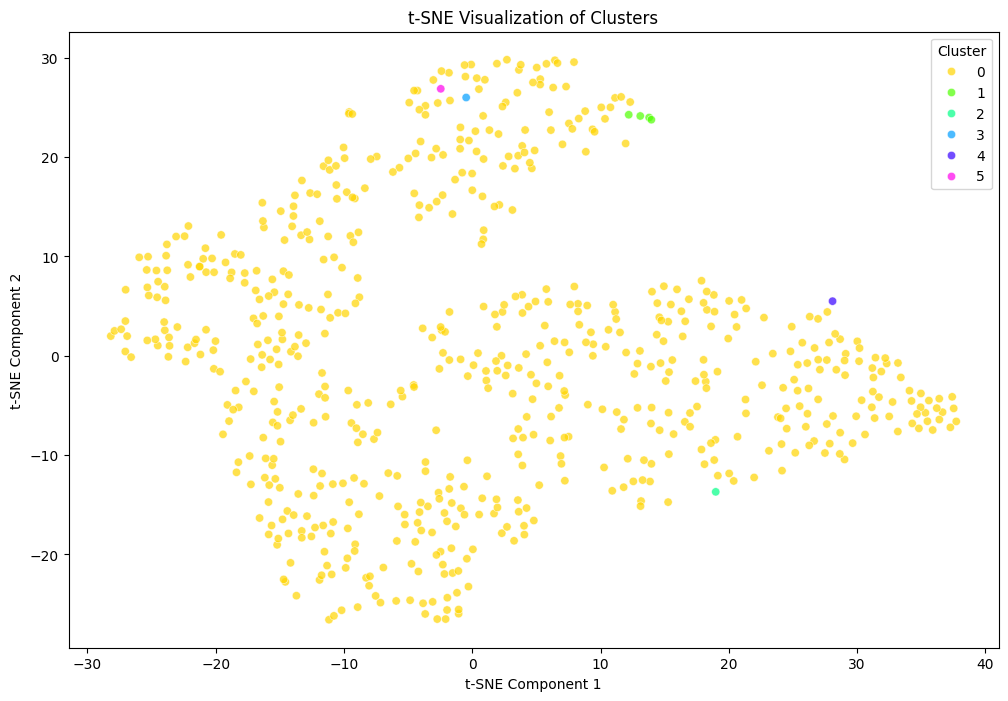

In [297]:
tsne_visualization(df,AgglomerativeClustering(n_clusters=5,linkage='average').fit_predict(df))
tsne_visualization(df,AgglomerativeClustering(n_clusters=5,linkage='ward').fit_predict(df))
tsne_visualization(df,AgglomerativeClustering(n_clusters=6,linkage='single').fit_predict(df))

threshold optimalization

mean of scaled silhouette and harabasz

because only looking at silhouette we will end up with one big cluster and onlu from harabasz with every point as cluster

In [330]:
best_score = -1
best_params = None

for thr in np.arange(0.2, 3, 0.2):
    for linkage_method in ['ward', 'complete', 'average', 'single']:
        clustering = AgglomerativeClustering(n_clusters=None, linkage=linkage_method,distance_threshold = thr)
        labels = clustering.fit_predict(df)
        score1 = calinski_harabasz_score(df, labels)
        score2 = silhouette_score(df,labels)*4000
        score = (score1+score2)/2
        #print(f'n_clusters: {n_clusters}, linkage: {linkage_method}, calinski harabasz: {score}')
        
        if score > best_score:
            best_score = score
            best_params = {'threshold': thr, 'linkage': linkage_method}

print('Best parameters:', best_params)

Best parameters: {'threshold': 2.2, 'linkage': 'ward'}


In [324]:
metrics( df,AgglomerativeClustering(n_clusters=None, linkage='ward',distance_threshold=2.2))

[0.2355378845842934, 0.8649920772901716, 97.80205274620442]

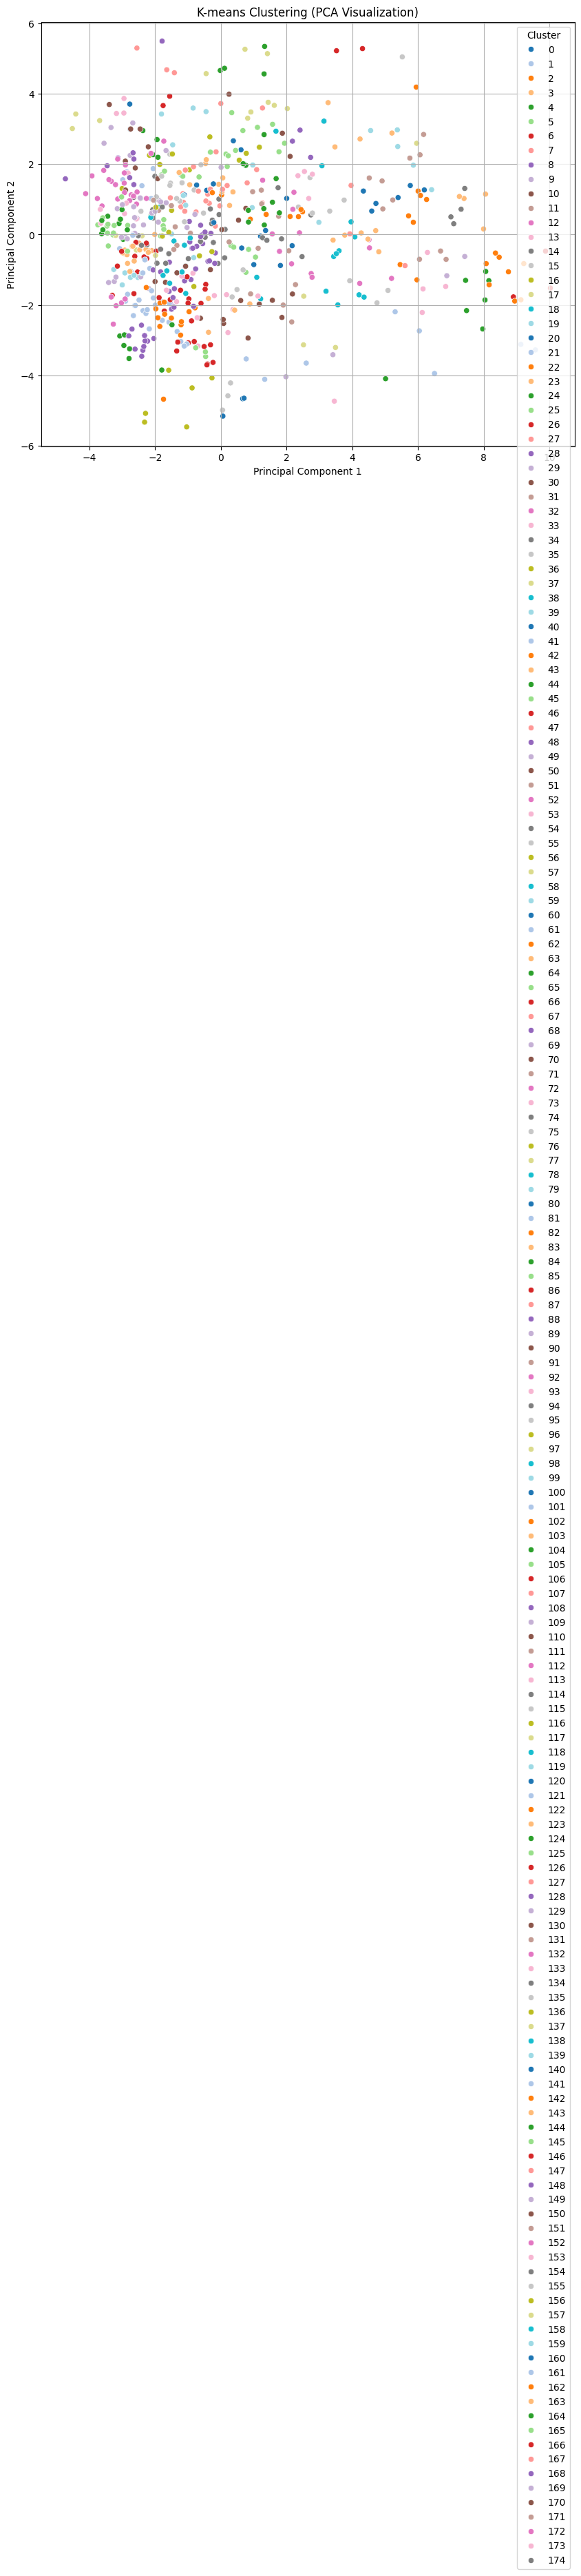

In [334]:
pca_visualization( df,AgglomerativeClustering(n_clusters=None, linkage='ward',distance_threshold=2.2).fit_predict(df))

In [337]:
# it gives us 179 clusters
agg_clusters = AgglomerativeClustering(n_clusters=None, linkage='ward',distance_threshold=2.2).fit_predict(df)
df2 = pd.read_csv('../Data/spotify_modelling.csv')
df2["cluster"] = agg_clusters
df2[df2.cluster ==69].head(7)

# całkiem podobne piosenki

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,cluster
427,Sticky,Drake,1,2022,6,17,2814,0,191448892,38,...,A#,Minor,88,8,49,9,0,9,14,69
462,Players,Coi Leray,1,2022,11,30,4096,6,335074782,118,...,F#,Major,95,62,52,3,0,5,16,69


In [ ]:
# to nie jest takie głupie i nie ma najgorszych metryk, ale chyba nie o to nam chodzi

# Chosen model

overall best model so far is kmeans with 5 clusters;
it scores :
- silhouete:0.2721160758450148
- davies: 1.1369315266790376
- harabasz 296.8450733663089

In [339]:
best_model =KMeans(n_clusters = 5,random_state = 14)
clusters = best_model.fit_predict(df)

In [340]:
df2 = pd.read_csv('../Data/spotify_modelling.csv')
df2 = preprocess_data2(df2)
interprete_clusters(df2,clusters)

,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,year_group_encoded,artist_popularity
cluster,,,,,,,,,,,,
0,3.0,2.0,2.0,2.0,3.0,3.0,3.0,5.0,3.0,1.0,1.0,5.0
1,4.0,5.0,1.0,3.0,2.0,4.0,2.0,3.0,5.0,4.0,2.0,4.0
2,2.0,1.0,5.0,5.0,5.0,5.0,1.0,1.0,4.0,3.0,5.0,1.0
3,1.0,4.0,4.0,4.0,4.0,2.0,4.0,2.0,1.0,5.0,4.0,2.0
4,5.0,3.0,3.0,1.0,1.0,1.0,5.0,4.0,2.0,2.0,3.0,3.0


we can see that :

- in cluster 0 for example there are mostly rap songs,

- in cluster 2 slow and instrumental songs by popular artists and 

- in cluster 4 energetic and party songs

In [341]:
df2 = pd.read_csv('../Data/spotify_modelling.csv')
df2["cluster"] = clusters
df2[df2.cluster ==0].head(7)

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,cluster
9,DOGTOOTH,"Tyler, The Creator",2,2023,3,27,1479,0,80758350,23,...,G#,Major,71,80,65,51,0,22,32,0
11,Surface Pressure,Jessica Darrow,1,2021,11,19,1756,0,267758538,38,...,D,Major,65,37,58,2,0,4,31,0
17,Major Distribution,"Drake, 21 Savage",2,2022,11,4,1545,0,154863153,22,...,G#,Minor,91,23,55,1,0,7,32,0
34,REMIX EXCLUSIVO,Feid,1,2023,3,17,1235,9,117206995,20,...,F,Minor,65,71,56,4,0,15,20,0
64,cï¿½ï¿½mo dormi,Rels B,1,2022,8,4,1452,35,331511413,16,...,C#,Major,63,56,43,24,0,12,23,0
85,Still D.R.E.,"Dr. Dre, Snoop Dogg",2,1999,1,1,33966,0,1210599487,141,...,B,Major,81,53,78,18,0,6,24,0
104,LA CANCIï¿½,"J Balvin, Bad Bunny",2,2019,6,28,6398,31,1435127549,177,...,G,Major,75,43,65,15,0,11,32,0


In [342]:
df2 = pd.read_csv('../Data/spotify_modelling.csv')
df2["cluster"] = clusters
df2[df2.cluster ==2].head(7)

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,cluster
4,Those Eyes,New West,1,2019,5,10,1507,14,411747614,24,...,E,Major,60,24,35,73,0,31,3,2
5,Crown,Kendrick Lamar,1,2022,5,13,1493,0,42485571,2,...,C#,Minor,37,14,24,80,0,11,4,2
12,Dos Oruguitas,Sebastian Yatra,1,2021,11,19,925,0,167076418,24,...,NaN,Major,42,47,36,76,0,9,5,2
19,Dream On,Aerosmith,1,1973,1,5,168,0,838586769,0,...,F,Minor,39,24,43,39,0,23,3,2
25,Boyfriends,Harry Styles,1,2022,5,20,1517,0,137070925,26,...,NaN,Major,42,32,20,94,0,11,4,2
41,Toxic,BoyWithUke,1,2021,9,10,1795,0,582981380,34,...,G#,Minor,59,69,61,84,0,46,36,2
43,Happier Than Ever,Billie Eilish,1,2021,7,30,8476,0,1056760045,138,...,NaN,Major,31,31,24,76,0,14,4,2


In [345]:
df2 = pd.read_csv('../Data/spotify_modelling.csv')
df2["cluster"] = clusters
df2[df2.cluster ==4].tail(7)

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,cluster
651,About Damn Time,Lizzo,1,2022,7,15,2332,2,723894473,0,...,A#,Minor,84,72,74,10,0,34,7,4
652,Me Porto Bonito,"Chencho Corleone, Bad Bunny",2,2022,5,6,8870,43,1440757818,104,...,C#,Minor,91,43,71,9,0,9,8,4
655,All The Way Live (Spider-Man: Across the Spide...,"Future, Lil Uzi Vert, Metro Boomin",3,2023,6,2,259,0,37126685,5,...,A,Minor,77,28,55,18,0,22,15,4
657,Miracle (with Ellie Goulding),"Calvin Harris, Ellie Goulding",2,2023,3,10,5120,48,211050784,161,...,A,Major,64,31,87,4,4,8,4,4
659,LADY GAGA,"Gabito Ballesteros, Junior H, Peso Pluma",3,2023,6,22,332,26,86444842,11,...,F,Minor,65,87,74,22,0,42,4,4
660,Una Noche en Medellï¿½,Cris Mj,1,2022,1,21,5415,32,682475162,46,...,A#,Minor,87,82,53,10,0,5,8,4
662,Cold Heart - PNAU Remix,"Dua Lipa, Elton John, Pnau",3,2017,11,10,21097,52,1605224506,384,...,C#,Major,80,92,80,4,0,10,3,4
